In [ ]:
import os

# Path to the dataset in Kaggle environment
dataset_path = '/kaggle/input/sports-image-classification/dataset/'

# List all files in the dataset directory
file_names = os.listdir(dataset_path)

# Example: print the first 5 files
print(file_names[:5])

# Now you can load your images from this path
print("you dataset is imported succefully ")

In [42]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard,  LearningRateScheduler
import datetime
import os
import cv2
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
print("all imports is successfully imported ")






all imports is successfully imported 


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
# Part I: Data Preparation

# 1. Load and Describe the Data
# Path to the dataset in Kaggle environment
train_data_path = '/kaggle/input/sports-image-classification/dataset/train.csv'
test_data_path = '/kaggle/input/sports-image-classification/dataset/test.csv'

# Load the CSV files
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
print("the data imported successfully")

the data imported successfully


In [28]:
print("Train CSV Info (8227 images):")
print(train_df.info())
print("\nTrain CSV Head:")
print(train_df.head())
print("\nTest CSV Info (2056 images):")
print(test_df.info())
print("\nTest CSV Head:")
print(test_df.head())

Train CSV Info (8227 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227 entries, 0 to 8226
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  8227 non-null   object
 1   label     8227 non-null   object
dtypes: object(2)
memory usage: 128.7+ KB
None

Train CSV Head:
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket

Test CSV Info (2056 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  2056 non-null   object
dtypes: object(1)
memory usage: 16.2+ KB
None

Test CSV Head:
         image_ID
0  f5e13966e7.jpg
1  6674191b4e.jpg
2  91b5f8b7a9.jpg
3  393119b6d6.jpg
4  1ce5f81578.jpg


In [34]:
image_col = 'image_ID'
label_col = 'label'

In [ ]:
print("\nLabel Distribution:")
print(train_df[label_col].value_counts())

In [ ]:
# 2. Clean the Data
print("\nMissing Values in Train CSV:")
print(train_df.isnull().sum())
train_df.dropna(inplace=True)

In [ ]:
print("\nNumber of Duplicates in Train CSV:", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

In [33]:
def verify_images(df, folder_path):
    missing_images = []
    for idx, row in df.iterrows():
        # Adjusted path to reflect Kaggle input directory
        img_path = os.path.join(folder_path, row[image_col])
        if not os.path.exists(img_path):
            missing_images.append(row[image_col])
    return missing_images

# Correct path to the dataset in Kaggle environment
train_images_folder = '/kaggle/input/sports-image-classification/dataset/train'

# Now call the function to verify images
missing_train_images = verify_images(train_df, train_images_folder)
print("\nMissing Training Images:", len(missing_train_images))

NameError: name 'image_col' is not defined

In [32]:
# 3. Load Images and Prepare for PCA
IMG_SIZE = 64
CHANNELS = 3  # Set to 3 for RGB; 

In [30]:
def load_images(df, folder_path, img_size=IMG_SIZE, for_pca=True):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(folder_path, row[image_col])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as RGB (3 channels)
        # To use grayscale (1 channel), replace the above line with:
        # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            if CHANNELS == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for consistency
            if for_pca:
                images.append(img.flatten())  # Flatten: 64x64x3 = 12288 for RGB, 64x64x1 = 4096 for grayscale
            else:
                images.append(img)  # Shape: (64, 64, 3) for RGB, (64, 64) for grayscale
            labels.append(row[label_col])
    return np.array(images), np.array(labels)
print("load image function run successfully")

load image function run successfully


In [35]:
X_pca, y = load_images(train_df, '/kaggle/input/sports-image-classification/dataset/train', for_pca=True)
X_cnn, _ = load_images(train_df, '/kaggle/input/sports-image-classification/dataset/train', for_pca=False)
X_cnn = X_cnn.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)  # Shape for CNN: (samples, 64, 64, 3) for RGB
# To use grayscale, ensure CHANNELS = 1 above, and this line will reshape to (samples, 64, 64, 1)

In [ ]:
# 4. PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')

# Display the plot instead of saving it
plt.show()  # This will show the plot


n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components}")
if n_components < X_pca.shape[1] * 0.5:
    print("PCA is useful: Significant dimensionality reduction achieved.")
    pca = PCA(n_components=n_components)
    X_pca_transformed = pca.fit_transform(X_scaled)
else:
    print("PCA is not useful: Most features are needed to explain variance.")
    X_pca_transformed = X_scaled

In [ ]:
# Add PCA Scatter Plot: Project data onto first two components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)  # Shape: (8227, 2)

# Explained variance for the first two components
var_pc1 = pca_2d.explained_variance_ratio_[0] * 100
var_pc2 = pca_2d.explained_variance_ratio_[1] * 100

# Create a scatter plot, coloring by sport labels
plt.figure(figsize=(10, 8))
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Use tab10 colormap for distinct colors

for idx, label in enumerate(unique_labels):
    mask = y == label
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                label=label, color=colors(idx), alpha=0.6, s=30)

plt.xlabel(f'Principal Component 1 ({var_pc1:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({var_pc2:.2f}% variance)')
plt.title('PCA: 2D Projection of Sports Images')
plt.legend()
plt.show()

In [36]:
# 5. Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

In [37]:
# Print original and encoded labels
print("Original Labels:", y[:10])  # Print the first 10 original labels
print("Encoded Labels:", y_encoded[:10])  # Print the first 10 encoded labels

# Print a mapping between original labels and encoded values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label to Encoded Value Mapping:", label_mapping)

# If you want to print the reverse mapping (encoded value to original label):
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
print("Encoded Value to Label Mapping:", reverse_label_mapping)


Original Labels: ['Badminton' 'Badminton' 'Badminton' 'Badminton' 'Cricket' 'Tennis'
 'Badminton' 'Swimming' 'Badminton' 'Badminton']
Encoded Labels: [0 0 0 0 1 5 0 4 0 0]
Label to Encoded Value Mapping: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}
Encoded Value to Label Mapping: {0: 'Badminton', 1: 'Cricket', 2: 'Karate', 3: 'Soccer', 4: 'Swimming', 5: 'Tennis', 6: 'Wrestling'}


In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_cnn, y_encoded, test_size=0.2, random_state=42)

In [39]:
# Compute the mean and standard deviation for the training set
train_mean = np.mean(X_train, axis=(0, 1, 2))  # Mean for each channel (RGB)
train_std = np.std(X_train, axis=(0, 1, 2))  # Std for each channel (RGB)

# Standardize the data using the mean and std computed from the training set
X_train_standardized = (X_train - train_mean) / train_std
X_val_standardized = (X_val - train_mean) / train_std  # Use the training set's mean and std for validation set

# Define the ImageDataGenerators for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()  # No augmentation for validation set

# Apply the standardization (mean subtraction and division by std) to the train and validation sets
train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=32)


In [ ]:
# 5. Check Consistency Between Training and Validation Data Standardization
print("\nEnsure that the training and validation data have similar mean and standard deviation:")
print("Training Mean:", np.mean(X_train_standardized, axis=(0, 1, 2)))
print("Validation Mean:", np.mean(X_val_standardized, axis=(0, 1, 2)))

print("\nTraining Std:", np.std(X_train_standardized, axis=(0, 1, 2)))
print("Validation Std:", np.std(X_val_standardized, axis=(0, 1, 2)))

In [ ]:
#visualize all data (not train data only )
plt.figure(figsize=(10, 6))
train_df[label_col].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Sport')
plt.ylabel('Count')

# Show the plot in the notebook instead of saving it
plt.show()



In [ ]:
# 8. Visualize Data



def visualize_data(train_images, train_labels, class_names):

    # Label distribution bar chart
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(train_labels, return_counts=True)
    plt.bar(class_names, counts)
    plt.title('Class Distribution')
    plt.xlabel('Sports Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # Pie chart for class distribution
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution (Pie Chart)')
    plt.show()

    # Image montage by class
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 3, figsize=(12, 4 * num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(train_labels == i)[0]
        sample_indices = np.random.choice(class_indices, 3, replace=False)
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(train_images[idx])
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(f'{class_name}')
    plt.tight_layout()
    plt.show()

    # Pixel intensity histograms
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        class_images = train_images[train_labels == i]
        mean_intensities = np.mean(class_images, axis=(1, 2, 3))  # Averaging over the image dimensions
        plt.hist(mean_intensities, bins=20, alpha=0.7, label=class_name)
    plt.title('Pixel Intensity Distribution by Class')
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage
visualize_data(X_train, y_train, class_names)

In [ ]:
# 9. Correlation Analysis (Interactive HTML Heatmap with Negative Correlations)
# Compute correlation matrix
pixel_corr = pd.DataFrame(X_pca).iloc[::5, ::5].corr()  # Shape: (2458, 2458)

# Check for negative correlations in the first subsampled matrix
print("\nChecking for negative correlations in first subsampled matrix:")
negative_corrs = pixel_corr[pixel_corr < 0].stack()
if not negative_corrs.empty:
    print(f"Found {len(negative_corrs)} negative correlations. Sample:")
    print(negative_corrs.head())
else:
    print("No negative correlations found.")

# Subsample to reduce size while ensuring negative correlations are included
step = 100  # Reduces from 2458 to ~25 (2458 / 100)
# Select indices to include some negative correlations
# Find pairs with negative correlations
neg_pairs = np.where(pixel_corr < -0.1)  # Threshold to find significant negative correlations
neg_indices = list(set(neg_pairs[0]))  # Unique indices with negative correlations

# Ensure we include some indices with negative correlations
num_indices_to_include = min(5, len(neg_indices))  # Include up to 5 indices with negative correlations
selected_neg_indices = neg_indices[:num_indices_to_include] if neg_indices else []

# Create a list of indices for subsampling, including negative correlation indices
subsample_indices = list(range(0, pixel_corr.shape[0], step))  # Default subsampling: 0, 100, ..., 2400
# Add some indices with negative correlations
for idx in selected_neg_indices:
    closest_subsample_idx = (idx // step) * step  # Align with step
    if closest_subsample_idx not in subsample_indices:
        subsample_indices.append(closest_subsample_idx)

subsample_indices = sorted(set(subsample_indices))  # Remove duplicates and sort
subsample_indices = subsample_indices[:25]  # Limit to 25 indices to keep heatmap manageable

# Subsample the correlation matrix using selected indices
subsampled_corr = pixel_corr.iloc[subsample_indices, subsample_indices].values

# Map subsampled indices back to original indices
original_indices = np.array(subsample_indices) * 5  # Map to original feature space: [0, 500, ..., 12000]

# Create tick labels for the heatmap
num_ticks = min(10, len(original_indices))
tick_positions = np.linspace(0, len(original_indices) - 1, num_ticks).astype(int)
tick_labels = original_indices[tick_positions]

# Create text annotations (rounded correlation values)
text_annotations = np.round(subsampled_corr, 2).astype(str)

# Create interactive heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=subsampled_corr,
    x=original_indices,
    y=original_indices,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlation'),
    text=text_annotations,
    texttemplate="%{text}",
    textfont=dict(size=10),
))

fig.update_layout(
    title='Pixel Correlation Heatmap (Subsampled)',
    xaxis_title='Pixel Index (Subsampled)',
    yaxis_title='Pixel Index (Subsampled)',
    xaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    yaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    autosize=True,
    margin=dict(l=50, r=50, t=100, b=50),
)

fig.write_html(
    'pixel_correlation_interactive.html',
    include_plotlyjs='cdn',
    post_script="""
    const style = document.createElement('style');
    style.innerHTML = `
        #graph { width: 100vw !important; height: 100vh !important; }
        body { margin: 0; padding: 0; overflow: hidden; }
    `;
    document.head.appendChild(style);
    """
)
print("\nInteractive heatmap saved as 'pixel_correlation_interactive.html'")
print("Open the HTML file in a browser to view the full-screen heatmap .")

In [40]:
# Part II: Training a Neural Network

# Requirement 1: Implement a CNN model
def create_cnn_model(num_layers=2, dropout_rate=0.2, weight_decay=0.0):
    """
    Creates a CNN model for sports image classification.
    
    Parameters:
    - num_layers: Number of convolutional layers
    - dropout_rate: Dropout rate for regularization
    - weight_decay: L2 regularization factor
    
    Returns:
    - Keras Sequential model
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)))
    for i in range(num_layers):
        model.add(layers.Conv2D(filters=32 * (2**i), kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))
    return model

# Requirement 2: Write a training function
def train_model(model, optimizer, batch_size, epochs=50):
    """
    Trains the model with early stopping and learning rate scheduling.
    
    Parameters:
    - model: CNN model to train
    - optimizer: Optimizer instance
    - batch_size: Batch size for training
    - epochs: Maximum number of epochs
    
    Returns:
    - History object
    """
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # Define the learning rate schedule
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)
    
    # Wrap the schedule to ensure the output is a Python float
    def schedule(epoch):
        lr = lr_schedule(epoch)
        return float(lr)  # Explicitly cast to Python float
    
    lr_scheduler = LearningRateScheduler(schedule)
    
    log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
        verbose=1
    )
    return history

# Requirement 3: Evaluate the model
def evaluate_model(model):
    """
    Evaluates the model on training and validation sets.
    
    Parameters:
    - model: Trained CNN model
    
    Returns:
    - Tuple of (train_accuracy, val_accuracy)
    """
    train_loss, train_acc = model.evaluate(train_generator, verbose=0)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc
def update_generators(batch_size):
    """
    Updates data generators with a new batch size.
    
    Parameters:
    - batch_size: New batch size
    """
    global train_generator, val_generator
    train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=batch_size)


In [ ]:
# Requirement 4: Explore hyperparameters
batch_sizes = [32, 64]
num_layers = [2, 3, 4]
dropout_rates = [0.2, 0.4]
optimizers = [
    {"name": "Adam", "class": Adam, "lr": 0.001},
    {"name": "SGD", "class": SGD, "lr": 0.01, "momentum": 0.9},
    {"name": "RMSprop", "class": RMSprop, "lr": 0.001}
]
weight_decays = [0.0, 0.01]

results = []
default_batch_size = 32
default_num_layers = 2
default_dropout_rate = 0.2
default_weight_decay = 0.0




print("\nExploring Batch Sizes:")
for bs in batch_sizes:
    update_generators(bs)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    optimizer = Adam(learning_rate=0.001)
    history = train_model(model, optimizer, bs)
    train_acc, val_acc = evaluate_model(model)
    results.append({'batch_size': bs, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Batch Size: {bs})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Batch Size: {bs})')
    plt.legend()
    plt.show()
    

In [ ]:
print("\nExploring Number of Layers:")
for nl in num_layers:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=nl, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    optimizer = Adam(learning_rate=0.001)
    history = train_model(model, optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'num_layers': nl, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Layers: {nl})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Layers: {nl})')
    plt.legend()
    plt.show()

print("\nExploring Dropout Rates:")
for dr in dropout_rates:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=dr, weight_decay=default_weight_decay)
    optimizer = Adam(learning_rate=0.001)
    history = train_model(model, optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'dropout_rate': dr, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Dropout: {dr})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Dropout: {dr})')
    plt.legend()
    plt.show()

print("\nExploring Optimizers:")
for opt_config in optimizers:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    optimizer = opt_config["class"](learning_rate=opt_config["lr"])
    if opt_config["name"] == "SGD":
        optimizer.momentum = opt_config["momentum"]
    history = train_model(model, optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'optimizer': opt_config["name"], 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Optimizer: {opt_config["name"]})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Optimizer: {opt_config["name"]})')
    plt.legend()
    plt.show()

print("\nExploring Weight Decay:")
for wd in weight_decays:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=wd)
    optimizer = Adam(learning_rate=0.001)
    history = train_model(model, optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'weight_decay': wd, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Weight Decay: {wd})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Weight Decay: {wd})')
    plt.legend()
    plt.show()

In [ ]:
#fuctions for training model with best hyper parameters 
# ========= BEST PARAMETERS =========
BEST_PARAMS = {
    'batch_size': 32,          # From your best_batch
    'num_layers': 3,           # From your best_layers (unused in structure)
    'dropout_rate': 0.2,       # From your best_dropout
    'weight_decay': 0.0,       # From your best_wd
    'optimizer': 'Adam',       # From your best_opt
    'learning_rate': 0.001     # Default for Adam
}

# ========= CONFIGURATION =========
IMG_SIZE    = 64
CHANNELS    = 3
NUM_CLASSES = 7   # adjust to your number of sports classes

IMAGE_COL = 'image_ID'
LABEL_COL = 'label'

# Paths in Kaggle environment
TRAIN_IMG_FOLDER = '/kaggle/input/sports-image-classification/dataset/train'
TEST_IMG_FOLDER  = '/kaggle/input/sports-image-classification/dataset/test'
TRAIN_CSV        = '/kaggle/input/sports-image-classification/dataset/train.csv'
TEST_CSV         = '/kaggle/input/sports-image-classification/dataset/test.csv'

# ===== FUNCTIONS DEFINITION =====
def verify_images(df, folder_path):
    missing = []
    for _, row in df.iterrows():
        path = os.path.join(folder_path, row[IMAGE_COL])
        if not os.path.exists(path):
            missing.append(row[IMAGE_COL])
    return missing


def load_images(df, folder_path, img_size=IMG_SIZE):
    imgs, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        labels.append(row[LABEL_COL])
    return np.array(imgs), np.array(labels)


def load_test_images(df, folder_path, img_size=IMG_SIZE):
    imgs = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return np.array(imgs)


def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=NUM_CLASSES):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(BEST_PARAMS['weight_decay'])),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(BEST_PARAMS['dropout_rate']),

        layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(BEST_PARAMS['weight_decay'])),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(BEST_PARAMS['dropout_rate']),

        layers.Conv2D(128,3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(BEST_PARAMS['weight_decay'])),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(BEST_PARAMS['dropout_rate']),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


def train_model(train_gen, val_gen, class_weight_dict, epochs=50):
    model = create_cnn_model()
    model.compile(
        optimizer=Adam(learning_rate=BEST_PARAMS['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    return model, history


def plot_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# ===== TRAINING PART for model with best hyper parameters =====
# 1) Load and verify training data
train_df = pd.read_csv(TRAIN_CSV)
missing = verify_images(train_df, TRAIN_IMG_FOLDER)
print(f"Missing train images: {len(missing)}")

# 2) Load all images and labels
X_all, y_all_raw = load_images(train_df, TRAIN_IMG_FOLDER)

# 3) Encode labels
le = LabelEncoder()
y_all = le.fit_transform(y_all_raw)

# 4) Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

# 5) Compute class weights
weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(weights))

# 6) Standardize data
train_mean = X_train.mean(axis=(0,1,2))
train_std  = X_train.std(axis=(0,1,2))
X_train_std = (X_train - train_mean) / train_std
X_val_std   = (X_val   - train_mean) / train_std

# 7) Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen  = ImageDataGenerator()

train_gen = train_datagen.flow(
    X_train_std, y_train,
    batch_size=BEST_PARAMS['batch_size']
)
val_gen = val_datagen.flow(
    X_val_std, y_val,
    batch_size=BEST_PARAMS['batch_size']
)

# 8) Train model
model, history = train_model(train_gen, val_gen, class_weight_dict)

# 9) Plot training history
plot_history(history)

In [ ]:
# ===== TESTING & SUBMISSION PART for model with best hyper parameter =====
# 1) Load and standardize test data
test_df = pd.read_csv(TEST_CSV)
X_test = load_test_images(test_df, TEST_IMG_FOLDER)
X_test_std = (X_test - train_mean) / train_std

test_datagen = ImageDataGenerator()
test_gen = test_datagen.flow(
    X_test_std,
    shuffle=False,
    batch_size=BEST_PARAMS['batch_size']
)

# 2) Predict and inspect distribution
preds = model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)
uniq, counts = np.unique(pred_classes, return_counts=True)
print("Prediction distribution:", dict(zip(uniq, counts)))

# 3) Save submission.csv
pred_labels = le.inverse_transform(pred_classes)
submission = pd.DataFrame({
    IMAGE_COL: test_df[IMAGE_COL],
    LABEL_COL: pred_labels
})
submission.to_csv('submission.csv', index=False)

# 4) Save final model
model.save('best_sports_classifier.keras')

# All Steps in more organized way 

# Functions definition

In [43]:
# ========= INITIAL PARAMETERS =========
BEST_PARAMS = {
    'batch_size': 32,
    'num_layers': 3,
    'dropout_rate': 0.2,
    'weight_decay': 0.0,
    'optimizer': 'Adam',
    'learning_rate': 0.001
}

# ========= CONFIGURATION =========
IMG_SIZE    = 64
CHANNELS    = 3
NUM_CLASSES = 7
IMAGE_COL   = 'image_ID'
LABEL_COL   = 'label'

# Paths
TRAIN_CSV     = '/kaggle/input/sports-image-classification/dataset/train.csv'
TEST_CSV      = '/kaggle/input/sports-image-classification/dataset/test.csv'
TRAIN_IMG_DIR = '/kaggle/input/sports-image-classification/dataset/train'
TEST_IMG_DIR  = '/kaggle/input/sports-image-classification/dataset/test'

# ===== FUNCTIONS =====
def verify_images(df, folder_path):
    missing = []
    for _, row in df.iterrows():
        if not os.path.exists(os.path.join(folder_path, row[IMAGE_COL])):
            missing.append(row[IMAGE_COL])
    return missing


def load_images(df, folder_path):
    imgs, labs = [], []
    for _, r in df.iterrows():
        img = cv2.imread(os.path.join(folder_path, r[IMAGE_COL]))
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if CHANNELS==3: img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img); labs.append(r[LABEL_COL])
    return np.array(imgs), np.array(labs)


def load_test_images(df, folder_path):
    imgs=[]
    for _, r in df.iterrows():
        img=cv2.imread(os.path.join(folder_path, r[IMAGE_COL]))
        if img is None: continue
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if CHANNELS==3: img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return np.array(imgs)


def create_cnn_model(nl, dr, wd):
    m = keras.Sequential([layers.Input((IMG_SIZE,IMG_SIZE,CHANNELS))])
    filters=[32,64,128]
    for f in filters[:nl]:
        m.add(layers.Conv2D(f,3,padding='same',activation='relu',
                             kernel_regularizer=regularizers.l2(wd)))
        m.add(layers.BatchNormalization())
        m.add(layers.MaxPooling2D())
        m.add(layers.Dropout(dr))
    m.add(layers.Flatten())
    m.add(layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(wd)))
    m.add(layers.BatchNormalization())
    m.add(layers.Dropout(dr))
    m.add(layers.Dense(NUM_CLASSES,activation='softmax'))
    return m


def get_generators(bs, X_tr, y_tr, X_va, y_va):
    aug = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,
                              height_shift_range=0.2,horizontal_flip=True)
    noaug= ImageDataGenerator()
    return aug.flow(X_tr,y_tr,batch_size=bs), noaug.flow(X_va,y_va,batch_size=bs)

# LOAD & PREPARE

In [49]:
# ===== LOAD & PREPARE =====
df = pd.read_csv(TRAIN_CSV)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f"Samples: {len(df)}; Missing: {len(verify_images(df, TRAIN_IMG_DIR))}")

# Load images and encode labels
X, y_txt = load_images(df, TRAIN_IMG_DIR)
le = LabelEncoder()
y = le.fit_transform(y_txt)

# Split into train/validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Standardize using training set statistics
m, std = X_tr.mean(axis=(0,1,2)), X_tr.std(axis=(0,1,2))
X_tr  = (X_tr  - m) / std
X_val = (X_val - m) / std

# Compute class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight

cw_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr),
    y=y_tr
)
cw = dict(enumerate(cw_values))


Samples: 8227; Missing: 0


Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 59s 256ms/step - accuracy: 0.4222 - loss: 1.7220 - val_accuracy: 0.3834 - val_loss: 1.9547
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - accuracy: 0.5713 - loss: 1.2109 - val_accuracy: 0.6428 - val_loss: 1.0324
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.6216 - loss: 1.0721 - val_accuracy: 0.6446 - val_loss: 1.0301
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.6386 - loss: 0.9956 - val_accuracy: 0.6537 - val_loss: 1.1285
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.6714 - loss: 0.9173 - val_accuracy: 0.6239 - val_loss: 1.2473
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 243ms/step - accuracy: 0.6911 - loss: 0.8674 - val_accuracy: 0.7090 - val_loss: 0.8624
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 249ms/step - accuracy: 0.6939 - loss: 0.8553 - val_accuracy: 0.7017 - val_loss: 0.8938
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.7204 - loss: 0

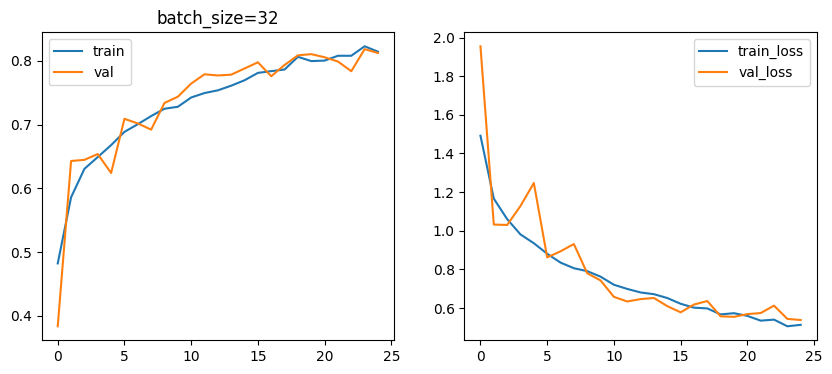

Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 66s 576ms/step - accuracy: 0.4151 - loss: 1.8193 - val_accuracy: 0.1361 - val_loss: 4.9626
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 60s 578ms/step - accuracy: 0.5778 - loss: 1.1937 - val_accuracy: 0.1513 - val_loss: 4.8516
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 59s 566ms/step - accuracy: 0.6329 - loss: 1.0738 - val_accuracy: 0.2734 - val_loss: 2.3130
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 82s 564ms/step - accuracy: 0.6597 - loss: 0.9761 - val_accuracy: 0.5304 - val_loss: 1.3894
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 551ms/step - accuracy: 0.6756 - loss: 0.9020 - val_accuracy: 0.6270 - val_loss: 1.1333
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 58s 561ms/step - accuracy: 0.7060 - loss: 0.8299 - val_accuracy: 0.7102 - val_loss: 0.8600
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 552ms/step - accuracy: 0.7171 - loss: 0.8037 - val_accuracy: 0.6640 - val_loss: 1.0324
Epoch 8/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 82s 554ms/step - accuracy: 0.7197 - loss: 0

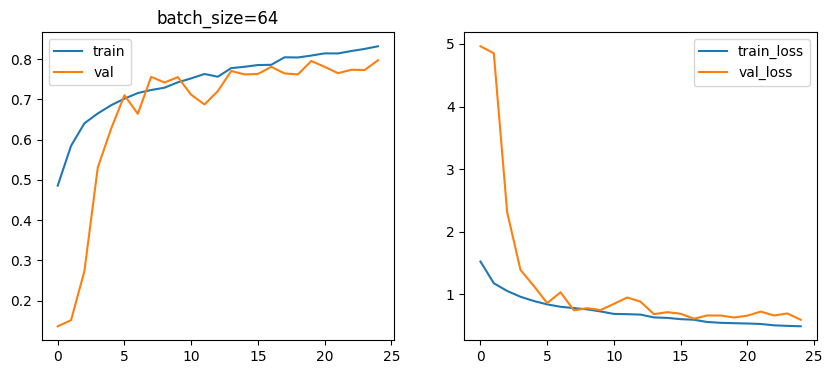

Best batch_size: 32 (acc=0.8123)


In [52]:
# ===== HYPERPARAM EXPLORATION =====
# Sequentially explore each hyperparameter while fixing others to defaults

# 1) Explore batch_size
batch_sizes = [32, 64]
results_bs = {}
for bs in batch_sizes:
    params = BEST_PARAMS.copy()
    params['batch_size'] = bs
    gen_tr, gen_val = get_generators(bs, X_tr, y_tr, X_val, y_val)

    # optimizer setup
    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[params['optimizer']]
    opt_kwargs = {'learning_rate': params['learning_rate']}
    if params['optimizer'] == 'SGD':
        opt_kwargs['momentum'] = 0.9
    opt = opt_cls(**opt_kwargs)

    # build and compile model
    model = create_cnn_model(params['num_layers'], params['dropout_rate'], params['weight_decay'])
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=[EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)],
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results_bs[bs] = val_acc

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f"batch_size={bs}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

BEST_PARAMS['batch_size'] = max(results_bs, key=results_bs.get)
print(f"Best batch_size: {BEST_PARAMS['batch_size']} (acc={results_bs[BEST_PARAMS['batch_size']]:.4f})")


Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 203ms/step - accuracy: 0.4262 - loss: 1.7463 - val_accuracy: 0.2509 - val_loss: 3.6090
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.5801 - loss: 1.2376 - val_accuracy: 0.6482 - val_loss: 1.0424
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - accuracy: 0.6120 - loss: 1.1074 - val_accuracy: 0.6987 - val_loss: 0.8667
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.6337 - loss: 1.0254 - val_accuracy: 0.6902 - val_loss: 0.8952
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.6691 - loss: 0.9472 - val_accuracy: 0.7017 - val_loss: 0.8980
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.6963 - loss: 0.8857 - val_accuracy: 0.7242 - val_loss: 0.8347
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.6790 - loss: 0.9060 - val_accuracy: 0.7132 - val_loss: 0.8785
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.6947 - loss: 0

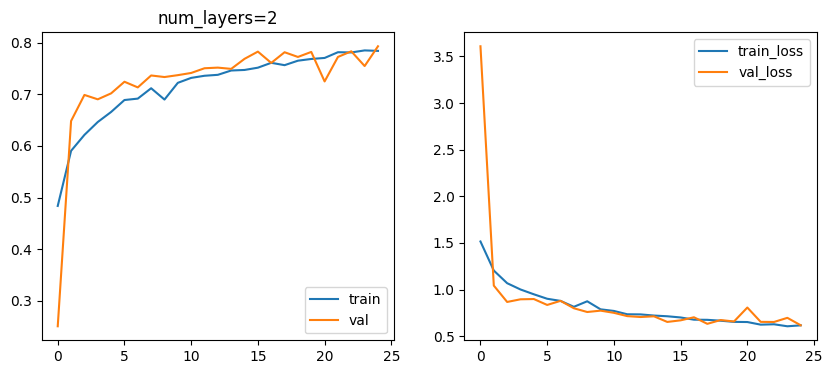

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 57s 245ms/step - accuracy: 0.4410 - loss: 1.7113 - val_accuracy: 0.1896 - val_loss: 5.1979
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.5838 - loss: 1.1726 - val_accuracy: 0.6160 - val_loss: 1.2741
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step - accuracy: 0.6466 - loss: 1.0113 - val_accuracy: 0.6628 - val_loss: 1.2841
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - accuracy: 0.6564 - loss: 0.9787 - val_accuracy: 0.6610 - val_loss: 1.0035
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 248ms/step - accuracy: 0.6875 - loss: 0.9055 - val_accuracy: 0.7114 - val_loss: 0.8628
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.7081 - loss: 0.8147 - val_accuracy: 0.7327 - val_loss: 0.7523
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 241ms/step - accuracy: 0.7119 - loss: 0.8207 - val_accuracy: 0.7284 - val_loss: 0.8625
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.7300 - loss: 0

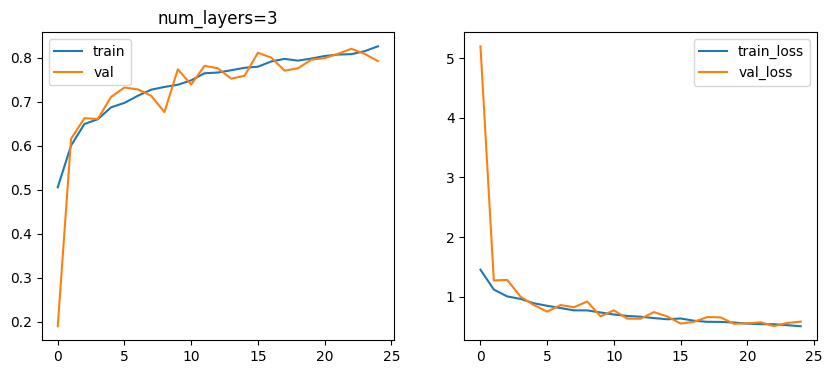

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 57s 247ms/step - accuracy: 0.4121 - loss: 1.7792 - val_accuracy: 0.1883 - val_loss: 5.4468
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.5696 - loss: 1.2272 - val_accuracy: 0.6057 - val_loss: 1.1544
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 238ms/step - accuracy: 0.6280 - loss: 1.0612 - val_accuracy: 0.6513 - val_loss: 0.9954
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.6387 - loss: 1.0074 - val_accuracy: 0.7005 - val_loss: 0.8442
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.6711 - loss: 0.9145 - val_accuracy: 0.7205 - val_loss: 0.7926
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.7056 - loss: 0.8376 - val_accuracy: 0.7005 - val_loss: 0.9038
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - accuracy: 0.6822 - loss: 0.9127 - val_accuracy: 0.7345 - val_loss: 0.7805
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - accuracy: 0.7119 - loss: 0

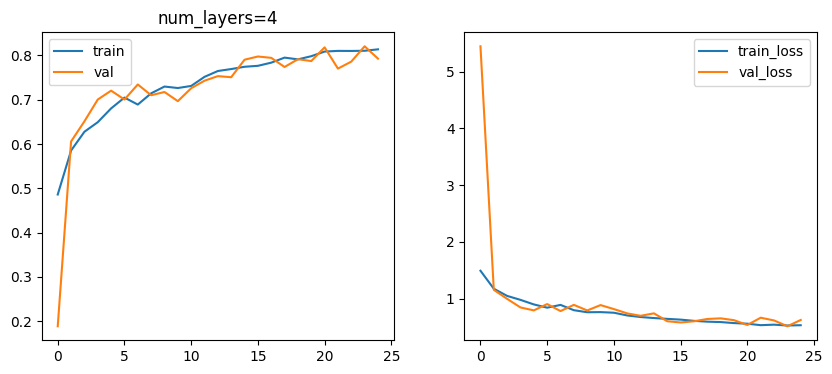

Best num_layers: 2 (acc=0.7928)


In [53]:
# 2) Explore num_layers
num_layers_list = [2, 3, 4]
results_nl = {}
for nl in num_layers_list:
    params = BEST_PARAMS.copy()
    params['num_layers'] = nl
    gen_tr, gen_val = get_generators(params['batch_size'], X_tr, y_tr, X_val, y_val)

    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[params['optimizer']]
    opt_kwargs = {'learning_rate': params['learning_rate']}
    if params['optimizer'] == 'SGD':
        opt_kwargs['momentum'] = 0.9
    opt = opt_cls(**opt_kwargs)

    model = create_cnn_model(nl, params['dropout_rate'], params['weight_decay'])
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=[EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)],
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results_nl[nl] = val_acc

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f"num_layers={nl}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

BEST_PARAMS['num_layers'] = max(results_nl, key=results_nl.get)
print(f"Best num_layers: {BEST_PARAMS['num_layers']} (acc={results_nl[BEST_PARAMS['num_layers']]:.4f})")

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.4123 - loss: 1.7735 - val_accuracy: 0.4423 - val_loss: 1.4763
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.5637 - loss: 1.2655 - val_accuracy: 0.6531 - val_loss: 0.9927
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.6259 - loss: 1.0607 - val_accuracy: 0.6628 - val_loss: 0.9747
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.6301 - loss: 1.0503 - val_accuracy: 0.6932 - val_loss: 0.8744
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.6674 - loss: 0.9517 - val_accuracy: 0.7041 - val_loss: 0.8280
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6971 - loss: 0.8837 - val_accuracy: 0.6932 - val_loss: 0.8413
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6891 - loss: 0.8642 - val_accuracy: 0.7132 - val_loss: 0.7948
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6959 - loss: 0

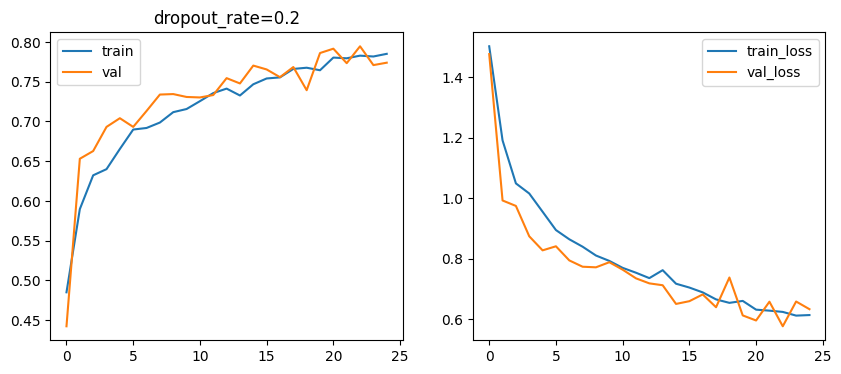

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.3516 - loss: 1.9877 - val_accuracy: 0.1938 - val_loss: 7.2226
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.5294 - loss: 1.3339 - val_accuracy: 0.2497 - val_loss: 8.0927
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.5555 - loss: 1.2432 - val_accuracy: 0.4739 - val_loss: 3.9638
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.5935 - loss: 1.1197 - val_accuracy: 0.4301 - val_loss: 7.2213
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.5911 - loss: 1.1353 - val_accuracy: 0.5796 - val_loss: 3.1679
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.6228 - loss: 1.0777 - val_accuracy: 0.6452 - val_loss: 1.6898
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.6433 - loss: 1.0141 - val_accuracy: 0.6458 - val_loss: 2.5877
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.6607 - loss: 0

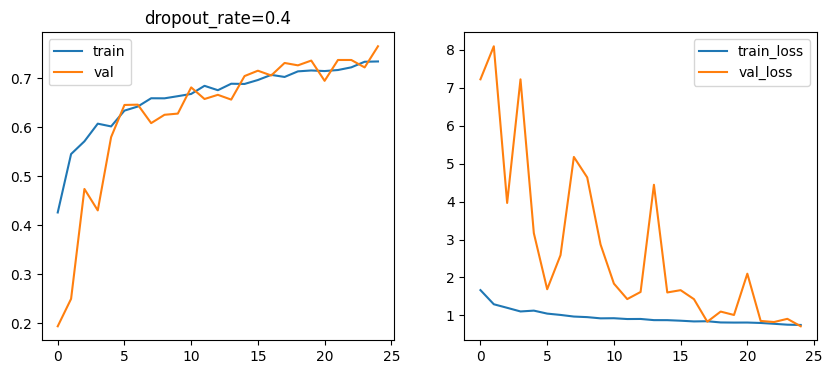

Best dropout_rate: 0.2 (acc=0.7740)


In [55]:
# 3) Explore dropout_rate
dropouts = [0.2, 0.4]
results_dr = {}
for dr in dropouts:
    params = BEST_PARAMS.copy()
    params['dropout_rate'] = dr
    gen_tr, gen_val = get_generators(params['batch_size'], X_tr, y_tr, X_val, y_val)

    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[params['optimizer']]
    opt_kwargs = {'learning_rate': params['learning_rate']}
    if params['optimizer'] == 'SGD':
        opt_kwargs['momentum'] = 0.9
    opt = opt_cls(**opt_kwargs)

    model = create_cnn_model(params['num_layers'], dr, params['weight_decay'])
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=[EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)],
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results_dr[dr] = val_acc

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f"dropout_rate={dr}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

BEST_PARAMS['dropout_rate'] = max(results_dr, key=results_dr.get)
print(f"Best dropout_rate: {BEST_PARAMS['dropout_rate']} (acc={results_dr[BEST_PARAMS['dropout_rate']]:.4f})")

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.4231 - loss: 1.7877 - val_accuracy: 0.2685 - val_loss: 2.4027
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.5763 - loss: 1.2132 - val_accuracy: 0.5972 - val_loss: 1.1952
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.6205 - loss: 1.0787 - val_accuracy: 0.6829 - val_loss: 0.9419
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.6403 - loss: 1.0081 - val_accuracy: 0.7084 - val_loss: 0.8489
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6617 - loss: 0.9673 - val_accuracy: 0.7224 - val_loss: 0.8000
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.6902 - loss: 0.8939 - val_accuracy: 0.7120 - val_loss: 0.8101
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.7002 - loss: 0.8417 - val_accuracy: 0.7242 - val_loss: 0.7846
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - accuracy: 0.7031 - loss: 0

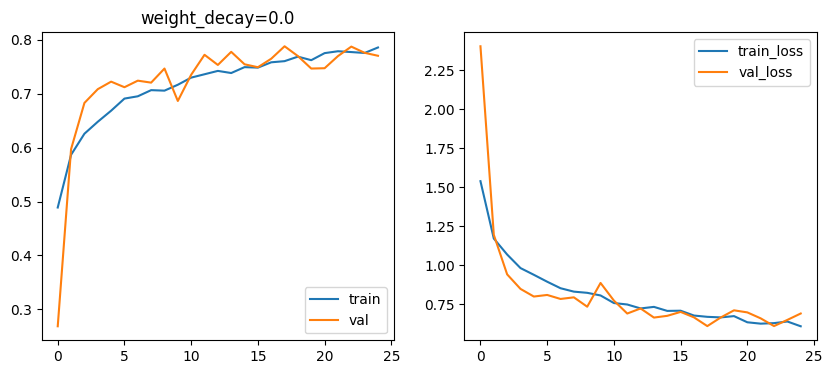

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.4081 - loss: 4.3622 - val_accuracy: 0.2874 - val_loss: 2.8570
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.5342 - loss: 2.3276 - val_accuracy: 0.4964 - val_loss: 2.1516
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.5719 - loss: 2.0566 - val_accuracy: 0.5966 - val_loss: 1.9107
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.6021 - loss: 1.8972 - val_accuracy: 0.6452 - val_loss: 1.7521
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6272 - loss: 1.7976 - val_accuracy: 0.6306 - val_loss: 1.7062
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.6263 - loss: 1.7545 - val_accuracy: 0.6409 - val_loss: 1.7012
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.6529 - loss: 1.6647 - val_accuracy: 0.5668 - val_loss: 1.9131
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.6594 - loss: 1

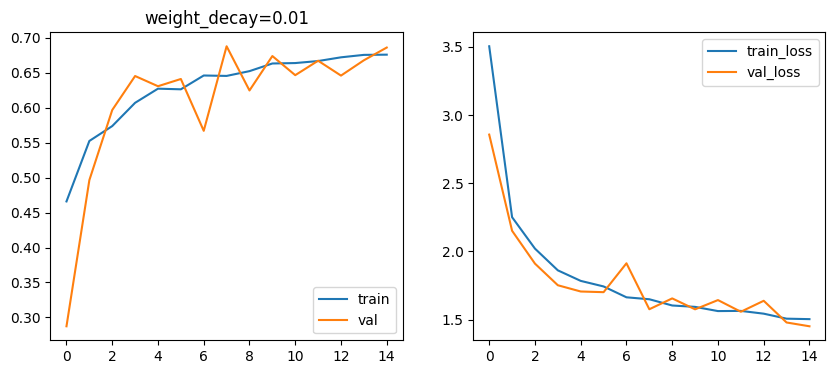

Best weight_decay: 0.0 (acc=0.7704)


In [57]:
# 4) Explore weight_decay
decays = [0.0, 0.01]
results_wd = {}
for wd in decays:
    params = BEST_PARAMS.copy()
    params['weight_decay'] = wd
    gen_tr, gen_val = get_generators(params['batch_size'], X_tr, y_tr, X_val, y_val)

    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[params['optimizer']]
    opt_kwargs = {'learning_rate': params['learning_rate']}
    if params['optimizer'] == 'SGD':
        opt_kwargs['momentum'] = 0.9
    opt = opt_cls(**opt_kwargs)

    model = create_cnn_model(params['num_layers'], params['dropout_rate'], wd)
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=[EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)],
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results_wd[wd] = val_acc

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f"weight_decay={wd}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

BEST_PARAMS['weight_decay'] = max(results_wd, key=results_wd.get)
print(f"Best weight_decay: {BEST_PARAMS['weight_decay']} (acc={results_wd[BEST_PARAMS['weight_decay']]:.4f})")

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - accuracy: 0.4150 - loss: 1.7865 - val_accuracy: 0.2284 - val_loss: 5.9641
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.5650 - loss: 1.2348 - val_accuracy: 0.5146 - val_loss: 1.9045
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.5996 - loss: 1.0938 - val_accuracy: 0.6403 - val_loss: 1.1737
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.6364 - loss: 1.0079 - val_accuracy: 0.6768 - val_loss: 0.9375
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.6517 - loss: 0.9768 - val_accuracy: 0.6835 - val_loss: 1.0984
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6731 - loss: 0.9221 - val_accuracy: 0.6883 - val_loss: 0.8981
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.6768 - loss: 0.9045 - val_accuracy: 0.7199 - val_loss: 0.8043
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6817 - loss: 0

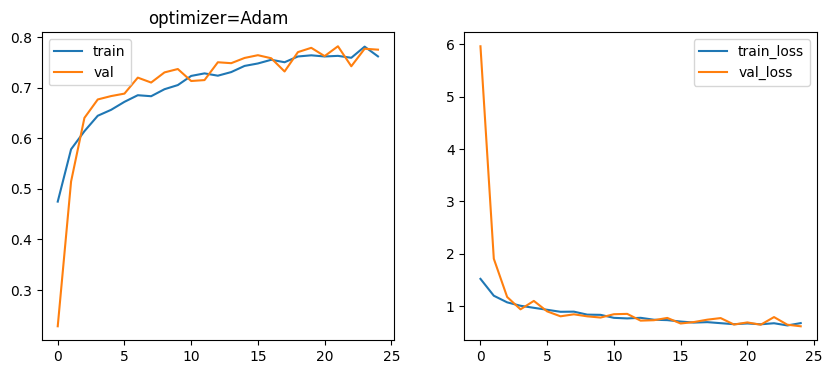

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.3817 - loss: 1.8482 - val_accuracy: 0.2959 - val_loss: 1.9769
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - accuracy: 0.5558 - loss: 1.2915 - val_accuracy: 0.5620 - val_loss: 1.2891
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.6100 - loss: 1.1484 - val_accuracy: 0.6288 - val_loss: 1.1145
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - accuracy: 0.6220 - loss: 1.0905 - val_accuracy: 0.5960 - val_loss: 1.4142
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6257 - loss: 1.0702 - val_accuracy: 0.6695 - val_loss: 1.0787
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.6540 - loss: 0.9843 - val_accuracy: 0.6993 - val_loss: 0.9262
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.6538 - loss: 0.9764 - val_accuracy: 0.6914 - val_loss: 0.9316
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - accuracy: 0.6721 - loss: 0

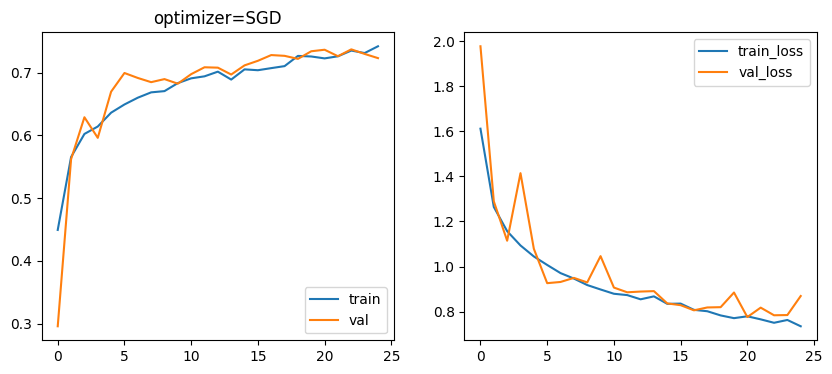

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.4195 - loss: 1.7619 - val_accuracy: 0.2442 - val_loss: 3.8355
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.5819 - loss: 1.1877 - val_accuracy: 0.6142 - val_loss: 1.1380
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6302 - loss: 1.0666 - val_accuracy: 0.6452 - val_loss: 1.0803
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6562 - loss: 0.9697 - val_accuracy: 0.6981 - val_loss: 0.8768
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6677 - loss: 0.9252 - val_accuracy: 0.7236 - val_loss: 0.8292
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - accuracy: 0.6782 - loss: 0.8856 - val_accuracy: 0.7096 - val_loss: 0.8420
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - accuracy: 0.7073 - loss: 0.8210 - val_accuracy: 0.6920 - val_loss: 0.9161
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.7185 - loss: 0

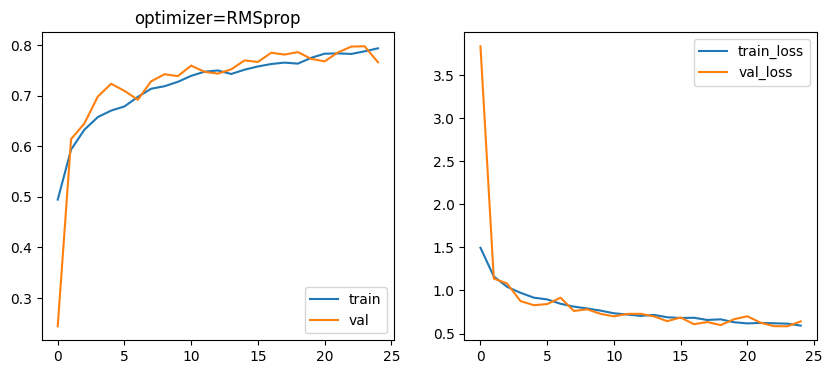

Best optimizer: Adam (acc=0.7752)


In [58]:
# 5) Explore optimizer
opt_list = [('Adam', Adam, {}), ('SGD', SGD, {'momentum':0.9}), ('RMSprop', RMSprop, {})]
results_opt = {}
for name, cls, extras in opt_list:
    params = BEST_PARAMS.copy()
    params['optimizer'] = name
    gen_tr, gen_val = get_generators(params['batch_size'], X_tr, y_tr, X_val, y_val)

    opt_kwargs = {'learning_rate': params['learning_rate']}
    opt_kwargs.update(extras)
    opt = cls(**opt_kwargs)

    model = create_cnn_model(params['num_layers'], params['dropout_rate'], params['weight_decay'])
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=[EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)],
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results_opt[name] = val_acc

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f"optimizer={name}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

BEST_PARAMS['optimizer'] = max(results_opt, key=results_opt.get)
print(f"Best optimizer: {BEST_PARAMS['optimizer']} (acc={results_opt[BEST_PARAMS['optimizer']]:.4f})")

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.4202 - loss: 1.7324 - val_accuracy: 0.2673 - val_loss: 3.5398
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.5547 - loss: 1.2726 - val_accuracy: 0.5978 - val_loss: 1.1800
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.6069 - loss: 1.1034 - val_accuracy: 0.6270 - val_loss: 1.1675
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.6216 - loss: 1.0697 - val_accuracy: 0.6926 - val_loss: 0.8937
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 190ms/step - accuracy: 0.6550 - loss: 0.9646 - val_accuracy: 0.7066 - val_loss: 0.8637
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.6780 - loss: 0.9100 - val_accuracy: 0.7193 - val_loss: 0.7990
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.6867 - loss: 0.8897 - val_accuracy: 0.7242 - val_loss: 0.7808
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.6938 - loss: 0

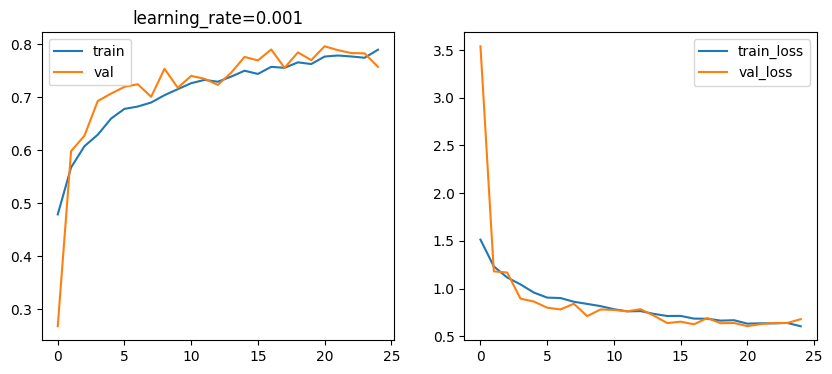

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.3922 - loss: 1.7689 - val_accuracy: 0.5559 - val_loss: 1.2179
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.5678 - loss: 1.1808 - val_accuracy: 0.6440 - val_loss: 1.0478
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.6220 - loss: 1.0358 - val_accuracy: 0.6106 - val_loss: 1.2039
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.6338 - loss: 1.0251 - val_accuracy: 0.6574 - val_loss: 1.0184
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6560 - loss: 0.9547 - val_accuracy: 0.7078 - val_loss: 0.8629
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.6731 - loss: 0.9325 - val_accuracy: 0.7047 - val_loss: 0.8318
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.6938 - loss: 0.8623 - val_accuracy: 0.7084 - val_loss: 0.8227
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.6823 - loss: 0

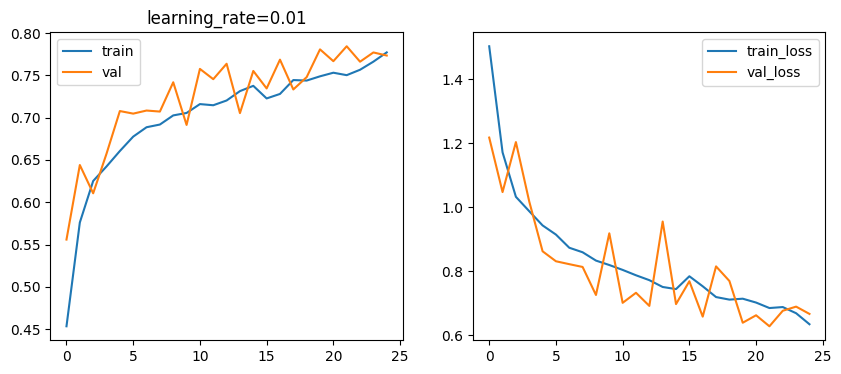

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.3127 - loss: 2.2763 - val_accuracy: 0.3688 - val_loss: 2.3644
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.4526 - loss: 1.5288 - val_accuracy: 0.4897 - val_loss: 4.0847
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.4363 - loss: 1.7274 - val_accuracy: 0.4672 - val_loss: 1.4558
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.4921 - loss: 1.4373 - val_accuracy: 0.4927 - val_loss: 1.3523
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.4971 - loss: 1.4335 - val_accuracy: 0.5389 - val_loss: 1.2684
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.5315 - loss: 1.3315 - val_accuracy: 0.5565 - val_loss: 1.4372
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.5506 - loss: 1.2949 - val_accuracy: 0.6209 - val_loss: 1.1240
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.5052 - loss: 1

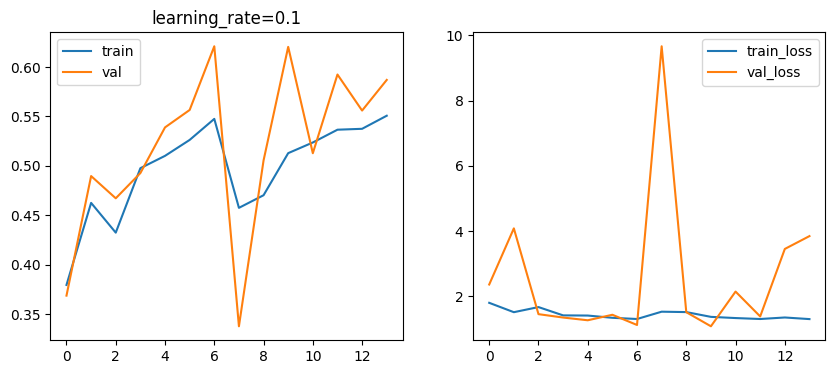

Best learning_rate: 0.01 (acc=0.7734)


In [59]:
# 6) Explore learning_rate
lrs = [0.001, 0.01, 0.1]
results_lr = {}
for lr in lrs:
    params = BEST_PARAMS.copy()
    params['learning_rate'] = lr
    gen_tr, gen_val = get_generators(params['batch_size'], X_tr, y_tr, X_val, y_val)

    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[params['optimizer']]
    opt_kwargs = {'learning_rate': lr}
    if params['optimizer'] == 'SGD':
        opt_kwargs['momentum'] = 0.9
    opt = opt_cls(**opt_kwargs)

    model = create_cnn_model(params['num_layers'], params['dropout_rate'], params['weight_decay'])
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=[EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)],
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results_lr[lr] = val_acc

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f"learning_rate={lr}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

BEST_PARAMS['learning_rate'] = max(results_lr, key=results_lr.get)
print(f"Best learning_rate: {BEST_PARAMS['learning_rate']} (acc={results_lr[BEST_PARAMS['learning_rate']]:.4f})")

In [62]:
# 7) Explore scheduler choice
from tensorflow.keras.callbacks import ReduceLROnPlateau

scheduler_options = {
    'none': None,
    'reduce_on_plateau': ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
}
results_sched = {}
for name, sched in scheduler_options.items():
    params = BEST_PARAMS.copy()
    gen_tr, gen_val = get_generators(params['batch_size'], X_tr, y_tr, X_val, y_val)

    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[params['optimizer']]
    opt_kwargs = {'learning_rate': params['learning_rate']}
    if params['optimizer']=='SGD': opt_kwargs['momentum']=0.9
    opt = opt_cls(**opt_kwargs)

    model = create_cnn_model(params['num_layers'], params['dropout_rate'], params['weight_decay'])
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    cbs = [EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)]
    if sched: cbs.append(sched)

    history = model.fit(
        gen_tr,
        validation_data=gen_val,
        epochs=25,
        callbacks=cbs,
        verbose=1
    )
    results_sched[name] = history.history['val_accuracy'][-1]

BEST_PARAMS['scheduler'] = max(results_sched, key=results_sched.get)
print(f"Best scheduler: {BEST_PARAMS['scheduler']} (acc={results_sched[BEST_PARAMS['scheduler']]:.4f})")

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.3733 - loss: 1.8107 - val_accuracy: 0.5158 - val_loss: 1.3123
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.5602 - loss: 1.2230 - val_accuracy: 0.6422 - val_loss: 1.0238
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6079 - loss: 1.0861 - val_accuracy: 0.6549 - val_loss: 0.9986
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.6286 - loss: 1.0322 - val_accuracy: 0.6488 - val_loss: 0.9850
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6379 - loss: 1.0043 - val_accuracy: 0.7072 - val_loss: 0.8405
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6643 - loss: 0.9545 - val_accuracy: 0.6744 - val_loss: 0.9576
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6737 - loss: 0.9249 - val_accuracy: 0.7078 - val_loss: 0.8927
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6857 - loss: 0

In [73]:
# ===== FINAL TRAIN & SUBMISSION =====
# 1) Prepare generators
gen_tr, gen_val = get_generators(
    BEST_PARAMS['batch_size'],
    X_tr, y_tr,
    X_val, y_val
)

# 2) Build optimizer
Opt = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[BEST_PARAMS['optimizer']]
opt_args = {'learning_rate': BEST_PARAMS['learning_rate']}
if BEST_PARAMS['optimizer'] == 'SGD':
    opt_args['momentum'] = 0.9
opt = Opt(**opt_args)

# 3) Build & compile model
final_model = create_cnn_model(
    BEST_PARAMS['num_layers'],
    BEST_PARAMS['dropout_rate'],
    BEST_PARAMS['weight_decay']
)
final_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4) Assemble callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('best_sports_classifier.keras', monitor='val_accuracy', save_best_only=True)
]
# Insert ReduceLROnPlateau if chosen
if BEST_PARAMS.get('scheduler') == 'reduce_on_plateau':
    callbacks.insert(
        1,
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    )

# 5) Train
hist = final_model.fit(
    gen_tr,
    validation_data=gen_val,
    epochs=90,
    callbacks=callbacks,
    verbose=1
)
val_loss, val_acc = final_model.evaluate(gen_val, verbose=0)
print("Validation accuracy:", val_acc)

Epoch 1/90


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 187ms/step - accuracy: 0.3765 - loss: 1.8322 - val_accuracy: 0.5693 - val_loss: 1.1809 - learning_rate: 0.0100
Epoch 2/90
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.5434 - loss: 1.2466 - val_accuracy: 0.5790 - val_loss: 1.1532 - learning_rate: 0.0100
Epoch 3/90
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.6085 - loss: 1.0959 - val_accuracy: 0.6434 - val_loss: 0.9790 - learning_rate: 0.0100
Epoch 4/90
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.6278 - loss: 1.0244 - val_accuracy: 0.6634 - val_loss: 0.9587 - learning_rate: 0.0100
Epoch 5/90
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6522 - loss: 0.9493 - val_accuracy: 0.6786 - val_loss: 0.9851 - learning_rate: 0.0100
Epoch 6/90
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6714 - loss: 0.9267 - val_accuracy: 0.6896 - val_loss: 0.8730 - learning_rate: 0.0100
Epoch 7/90
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6938 - loss:

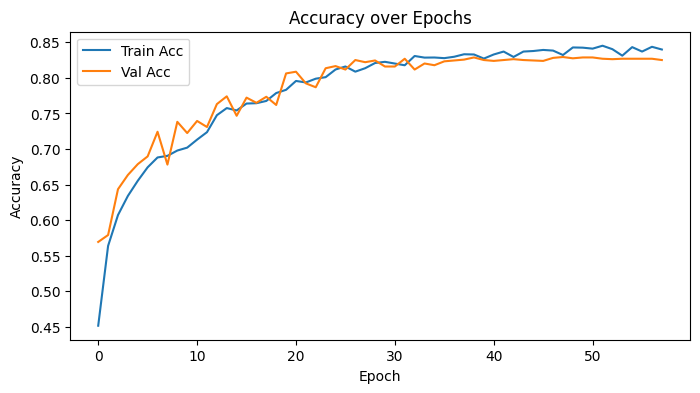

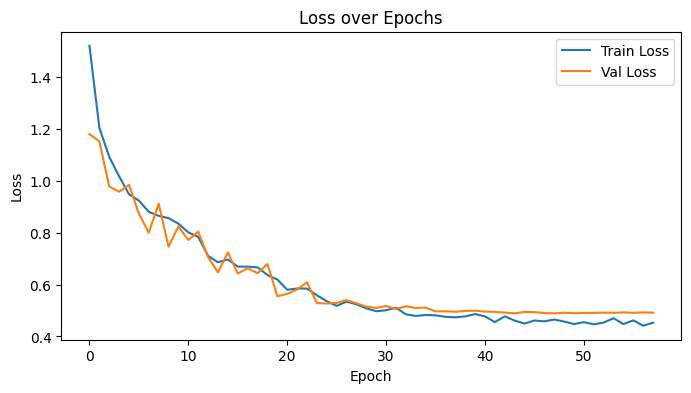

modelsaved


In [77]:
# 6) Plot history and evaluate
# Plot accuracy
plt.figure(figsize=(8,4))
plt.plot(hist.history['accuracy'],    label='Train Acc')
plt.plot(hist.history['val_accuracy'],label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'],    label='Train Loss')
plt.plot(hist.history['val_loss'],label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.show()

# 7) Save final model
final_model.save('best_sports_classifier.keras')
print("modelsaved")

In [66]:
print(BEST_PARAMS)

{'batch_size': 32, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.0, 'optimizer': 'Adam', 'learning_rate': 0.01, 'scheduler': 'reduce_on_plateau'}


In [78]:
# ===== TEST PREDICTION & SUBMISSION =====
# Load test metadata
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df_test = pd.read_csv(TEST_CSV)
# Load and preprocess test images
df_test = pd.read_csv(TEST_CSV)
X_test = load_test_images(df_test, TEST_IMG_DIR)
# Standardize using training mean and std
X_test = (X_test - m) / std
# Create test generator
test_gen = ImageDataGenerator().flow(
    X_test,
    shuffle=False,
    batch_size=BEST_PARAMS['batch_size']
)
# Predict
preds = final_model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)
# Map back to original labels
pred_labels = le.inverse_transform(pred_classes)
# Save submission.csv
submission_df = pd.DataFrame({
    IMAGE_COL: df_test[IMAGE_COL],
    LABEL_COL: pred_labels
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' saved.")

 3/65 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Submission file 'submission.csv' saved.


In [68]:
print("all cells successfully trained ")

all cells successfully trained 


In [79]:
import os
from IPython.display import FileLink, display

# Paths (assumed already in /kaggle/working)
model_path = 'best_sports_classifier.keras'
sub_path   = 'submission.csv'
zip_path   = 'output.zip'

# 1) Zip them (if you want one download)
#    - the `-j` flag puts them in the root of the zip without folders
!zip -j {zip_path} {model_path} {sub_path}

# 2) Display download links
display(FileLink(model_path, result_html_prefix="🗄️ Download model: "))
display(FileLink(sub_path,   result_html_prefix="📄 Download submission: "))
display(FileLink(zip_path,   result_html_prefix="📦 Download both as ZIP: "))


updating: best_sports_classifier.keras (deflated 8%)
updating: submission.csv (deflated 67%)


/kaggle/working/best_sports_classifier.keras

/kaggle/working/submission.csv

/kaggle/working/output.zip